In [48]:
import pandas as pd
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
import numpy as np
from keras.layers import Embedding, SimpleRNN,Input
from keras.models import Sequential,Model
from keras.preprocessing import sequence
from keras.layers import Dense,Dropout
from keras.layers import Embedding, Flatten, Dense,Conv1D,MaxPooling1D
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools    
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from collections import Counter
import tensorflow as tf
from keras.layers import LSTM, Bidirectional, Dropout

**LOAD DATA**

In [2]:
election = pd.read_csv('election.csv')

In [3]:
election.head()

,id,clean_text,polarity,place
0,1.11772E+18,RT chitraSD Jogging RahulGandhi ’ memory famil...,0,Madras
1,1118061974292533249,AAP INC want alliance stop division Anti-Modi ...,0,NaN
2,1117870131969810432,RT pankaj_shankar She priyankagandhi slams Mod...,0,NaN
3,1.1177E+18,RT airnewsalerts SC says RahulGandhi 's remark...,0,New Delhi
4,1117850484327366656,RT sachinsingh1010 75 year old Govindraj kille...,0,New Delhi Varanasi


further clean the tweets before moving ahead. The below function will remove 'RT',the URL's, converts the text to lower case and allows only alphabets to be contained in the tweet.

In [4]:
def tweet_to_words( raw_review ):
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', letters_only) # remove URLs
    tweet = re.sub('RT', ' ', str(tweet)) 

    #Convert to lower case, split into individual words
    tweet = letters_only.lower().split()                             
    
    
    
    return( " ".join(tweet))

In [25]:
# Get the number of Tweets based on the dataframe column size
num_tweets = 10365
vocab_size = 10000
rnn_cell_size = 128


clean_train_tweets = []

# Loop over each tweet; create an index i that goes from 0 to the length
# of the tweet list 
for i in range( 0, num_tweets ):
    # Call function for each one, and add the result to the list of
    # clean reviews
    clean_train_tweets.append( tweet_to_words( election["clean_text"][i] ) )

In [10]:
data_inputs =  clean_train_tweets
data_labels = list(election.polarity)

**TOKENIZE DATA**

We tokenize the text and keep the maximum length of the the vector 1000.

In [20]:
tokenizer = Tokenizer(nb_words=2000)
tokenizer.fit_on_texts(data_inputs)
sequences = tokenizer.texts_to_sequences(data_inputs)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_len = 200
data = pad_sequences(sequences, max_len)

labels = keras.utils.to_categorical(np.asarray(data_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

C:\Users\Abhishek\Anaconda3_NEW\lib\site-packages\keras_preprocessing\text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 8213 unique tokens.
Shape of data tensor: (10365, 200)
Shape of label tensor: (10365, 2)


In [12]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(.20 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

**MODEL CREATION**

In [50]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(2, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - Bidirectional LSTM")
model.summary()
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=100, batch_size=50)

model fitting - Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 100)          821400    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 982,602
Trainable params: 161,202
Non-trainable params: 821,400
_________________________________________________________________


C:\Users\Abhishek\Anaconda3_NEW\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 8292 samples, validate on 2073 samples
Epoch 1/100
8292/8292 [==============================] - 42s 5ms/step - loss: 0.3838 - acc: 0.8257 - val_loss: 0.2738 - val_acc: 0.8688
Epoch 2/100
8292/8292 [==============================] - 41s 5ms/step - loss: 0.2253 - acc: 0.9038 - val_loss: 0.1811 - val_acc: 0.9310
Epoch 3/100
8292/8292 [==============================] - 42s 5ms/step - loss: 0.1570 - acc: 0.9395 - val_loss: 0.1696 - val_acc: 0.9339
Epoch 4/100
8292/8292 [==============================] - 42s 5ms/step - loss: 0.1102 - acc: 0.9582 - val_loss: 0.1124 - val_acc: 0.9629
Epoch 5/100
8292/8292 [==============================] - 42s 5ms/step - loss: 0.0825 - acc: 0.9713 - val_loss: 0.1106 - val_acc: 0.9653
Epoch 6/100
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0665 - acc: 0.9762 - val_loss: 0.2136 - val_acc: 0.9276
Epoch 7/100
8292/8292 [==============================] - 41s 5ms/step - loss: 0.0525 - acc: 0.9822 - val_loss: 0.1227 - val_acc: 0.9609


**SAVING MODEL AND WEIGHTS**

In [58]:
# serialize model to JSON
model_json = model.to_json()
with open(".\\SavedModels\\Model_Bidir_LSTM.h5", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(".\\SavedModels\\Weights_bidir_LSTM.h5")
print("Saved model to disk")

Saved model to disk


**MODEL LOSS AND ACCURACY**

In [61]:
loss,acc = model.evaluate(x_val,y_val, verbose = 2, batch_size = 50)
print("Validation Loss: %.2f" % (loss))
print("Validation Accuracy: %.2f" % (acc))

Validation Loss: 0.20
Validation Accuracy: 0.98


**MODEL PERFORMANCE**

In [62]:
def plot_modelacc(fit_model):
    with plt.style.context('ggplot'):
            plt.plot(fit_model.history['acc'])
            plt.plot(fit_model.history['val_acc'])
            plt.ylim(0,1)
            plt.title("MODEL ACCURACY")
            plt.xlabel("# of EPOCHS")
            plt.ylabel("ACCURACY")
            plt.legend(['train', 'test'], loc='upper left')
    return plt.show()

In [63]:
def plot_model_loss(fit_model):
    with plt.style.context('ggplot'):
            plt.plot(fit_model.history['loss'])
            plt.plot(fit_model.history['val_loss'])
            plt.title("MODEL LOSS")
            plt.xlabel("# of EPOCHS")
            plt.ylabel("LOSS")
            plt.legend(['train', 'test'], loc='upper left')
    return plt.show()

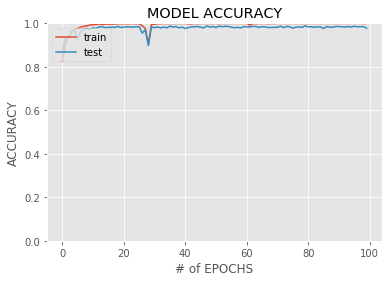

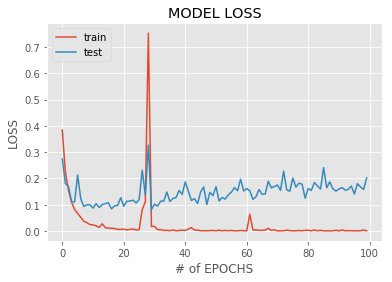

In [65]:
plot_modelacc(model.history)
plot_model_loss(model.history)

**CONFUSION MATRIX**

[[1140   35]
 [  11  887]]


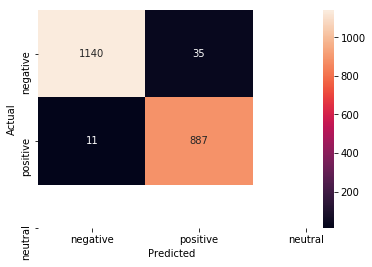

In [66]:
# Predicting the Test set results
y_pred = model.predict(x_val)
# cutoff 0.5
y_pred = (y_pred > 0.5)

y_pred = y_pred.astype(int)


# Confusion matrix 
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

LABELS = ['negative', 'positive','neutral']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actual")

True Positives: 887(Predicted True and True in reality)<br>
True Negative: 1140(Predicted False and False in realtity)<br>
False Positive: 35 (Predicted Positve but Negative in reality)<br>
False Negative: 11 (Predicted Negative but Positive in reality)